In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_columns', None)
df = pd.read_csv(r"C:\Users\ephre\Documents\Rossmann-Pharmaceuticals-Finance-1\Data\Train_Data\cleaned_Train_dataset.csv")


C:\Users\ephre\AppData\Local\Temp\ipykernel_23732\2573679355.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r"C:\Users\ephre\Documents\Rossmann-Pharmaceuticals-Finance-1\Data\Train_Data\cleaned_Train_dataset.csv")


In [3]:
# Isolate relevant columns for time series (e.g., Date and Sales)
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
time_series_data = df[['Date', 'Sales']].set_index('Date')

In [4]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(timeseries):
    # Perform ADF test
    result = adfuller(timeseries)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    for key, value in result[4].items():
        print(f'Critical Value {key}: {value}')

# Convert Sales column to float32 to reduce memory usage
time_series_data['Sales'] = time_series_data['Sales'].astype(np.float32)

# Reduce data size by sampling (e.g., 50% of the data)
sampled_data = time_series_data['Sales'].sample(frac=0.4, random_state=42)

# Check stationarity on sampled data
check_stationarity(sampled_data)



ADF Statistic: -637.8843967118789
p-value: 0.0
Critical Value 1%: -3.43036607179768
Critical Value 5%: -2.86154710354182
Critical Value 10%: -2.566773780956451


In [5]:
# Check for duplicate indices
duplicate_indices = time_series_data.index.duplicated()

# Display the rows with duplicate indices
print(time_series_data[duplicate_indices])


              Sales
Date               
2013-01-01      0.0
2013-01-01      0.0
2013-01-01      0.0
2013-01-01      0.0
2013-01-01      0.0
...             ...
2015-07-31   9082.0
2015-07-31  10708.0
2015-07-31   7481.0
2015-07-31  10460.0
2015-07-31   5263.0

[1016267 rows x 1 columns]


In [6]:
# Aggregate duplicate indices by averaging the values
time_series_data = time_series_data.groupby(time_series_data.index).mean()


In [7]:
# Differencing to remove trend and make the data stationary
time_series_data['Sales_diff'] = time_series_data['Sales'].diff().dropna()

# Check stationarity again
check_stationarity(time_series_data['Sales_diff'].dropna())


ADF Statistic: -13.971463073031202
p-value: 4.337546330137073e-26
Critical Value 1%: -3.437470108019385
Critical Value 5%: -2.8646832620852853
Critical Value 10%: -2.5684436698650503


<Figure size 1000x600 with 0 Axes>

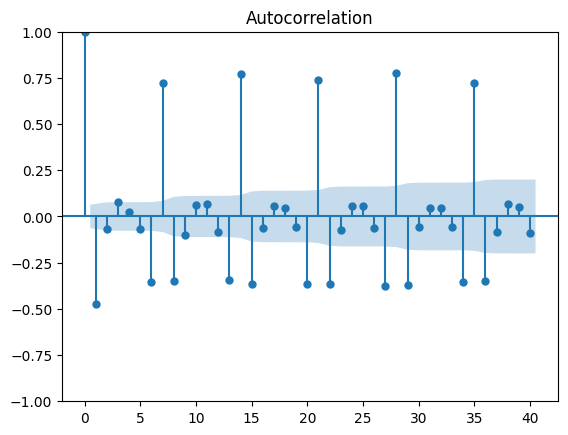

<Figure size 1000x600 with 0 Axes>

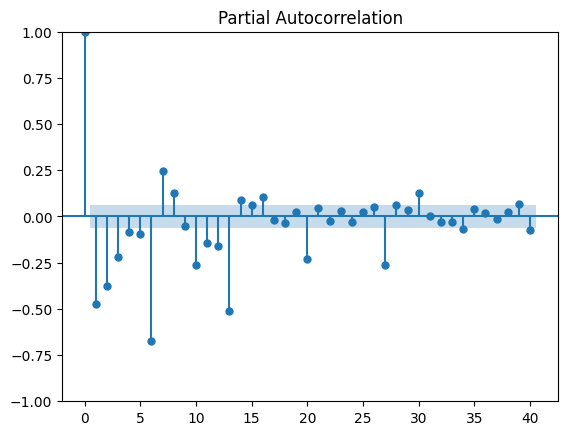

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(10,6))
plot_acf(time_series_data['Sales_diff'].dropna(), lags=40)
plt.show()

plt.figure(figsize=(10,6))
plot_pacf(time_series_data['Sales_diff'].dropna(), lags=40)
plt.show()


In [9]:
def create_supervised_data(series, n_lags=1):
    X, y = [], []
    for i in range(len(series)-n_lags):
        X.append(series[i:i+n_lags])
        y.append(series[i+n_lags])
    return np.array(X), np.array(y)

n_lags = 7  # Number of time steps to look back
sales_data = time_series_data['Sales'].dropna().values

# Create supervised data
X, y = create_supervised_data(sales_data, n_lags=n_lags)

# Reshape data for LSTM (samples, time steps, features)
X = X.reshape(X.shape[0], X.shape[1], 1)


In [10]:
scaler = MinMaxScaler(feature_range=(-1, 1))
X_scaled = scaler.fit_transform(X.reshape(-1, 1)).reshape(X.shape)
y_scaled = scaler.transform(y.reshape(-1, 1))


In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(n_lags, 1)))
model.add(LSTM(50))
model.add(Dense(1))  # Output layer for regression (predict sales)

model.compile(optimizer='adam', loss='mean_squared_error')


c:\Users\ephre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.1844 - val_loss: 0.1747
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1727 - val_loss: 0.1715
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1673 - val_loss: 0.1634
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1446 - val_loss: 0.1511
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1375 - val_loss: 0.1197
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1233 - val_loss: 0.1147
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1205 - val_loss: 0.1086
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1004 - val_loss: 0.0913
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0930 - val_loss: 0.0924
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0975 - val_loss: 0.0871
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0845 - val_loss: 0.0903
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0763 - val_l

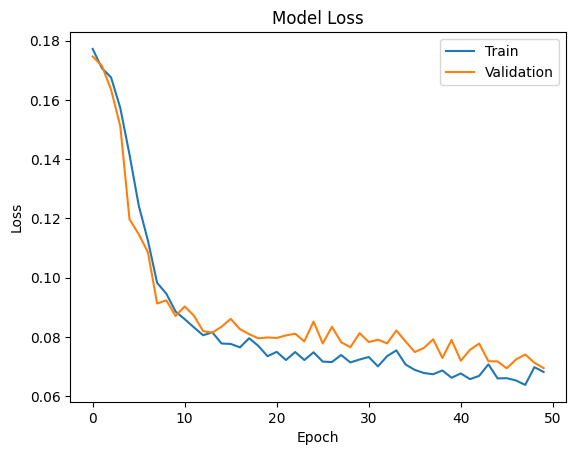

In [12]:
# Train the LSTM model
history = model.fit(X_scaled, y_scaled, epochs=50, batch_size=32, validation_split=0.2)

# Plot training loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


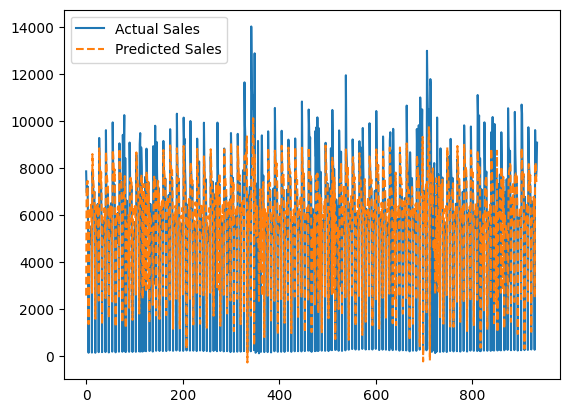

In [13]:
# Make predictions
y_pred_scaled = model.predict(X_scaled)

# Inverse scale the predictions
y_pred = scaler.inverse_transform(y_pred_scaled)

# Compare predictions with actual values
plt.plot(sales_data[n_lags:], label='Actual Sales')
plt.plot(y_pred, label='Predicted Sales', linestyle='--')
plt.legend()
plt.show()
